<h1> Final assignment description </h1>

The objective is to classify three different classes of ECG signals.
-<h3> Normal sinus rythm; </h3> <br> 
![Normal sinus rythm](img/normal.PNG)
-<h3> Premature ventricular complex (PVC); </h3> <br>
![PAC](img/pvc.PNG)
-<h3> Premature atrial complex (PAC); </h3> <br>
![PVC](img/pac.PNG)


We must classify each beat of the signal and each beat of the training set is labelled with:
- N: normal sinus rythm; <br>
- S: supraventricular beats (PAC); <br>
- V: ventricular beats (PVC); <br>

<h2>Dataset </h2>

- 105 patients;
- fs: 128 or 250 Hz;
- 2 leads ECG -> 2 ecg signal for each patient; 
- Rpeaks are annotated in the dedicated .mat file;

File format: 
- [PatientID]\_[fs]+".mat" $\rightarrow$ 2 leads ECG signal;
- [PatientID]\_[fs]+\_[ann]+".mat" $\rightarrow$ labelling of the Rpeaks;
- [PatientID]\_[fs]+\_[rpk]+".mat" $\rightarrow$ Rpeaks location in the signal (at which time an Rpeak appears);

In [114]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image

In [115]:
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)

<h2>Load the dataset</h2>

In [116]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
  label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
  peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
  signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
  if os.path.isfile(label_filepath):
    mat_file = loadmat(label_filepath)
    label = np.asarray(mat_file['labels'])
  if os.path.isfile(peak_filepath):
    mat_file = loadmat(peak_filepath)
    peak = np.asarray(mat_file['rpeaks'])
  if os.path.isfile(signal_filepath):
    mat_file = loadmat(signal_filepath)
    signal = np.asarray(mat_file['ecg'] )

  return label, peak, signal


labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

<h2>Data visualization</h2>

In [117]:

def plot_signal(sigID,length):
    
    signal = ecg_signals[sigID]

    x = np.arange(length)
    y = signal[:length,0]
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=2.0)

    # we are plotting only the defined time, so we must count how many peaks 
    peak_counter = 0
    
    for peak in rpeaks[sigID][:,0]:
        if (peak > length):
            break
        peak_counter += 1
    
    x = rpeaks[sigID][:peak_counter,0]  # time values of the peaks in between the defined length 
    y = ecg_signals[sigID][x,0]         # amplitude value of the peaks 
    
    ax.scatter(x,y,color = "red")

    peaks_labels = labels[sigID][:peak_counter] 
    offset = 20
    for i,label in enumerate(peaks_labels):
        ax.annotate(label,(x[i]-offset,y[i]),fontsize = "large")

    plt.show()
    

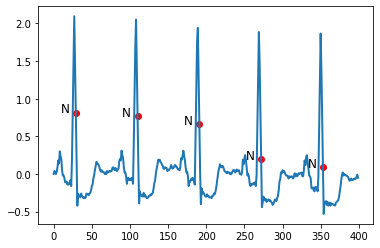

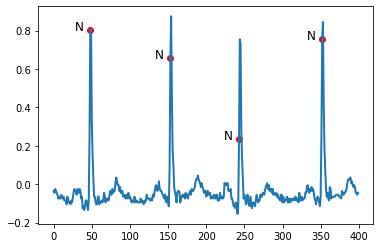

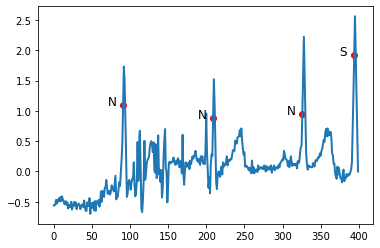

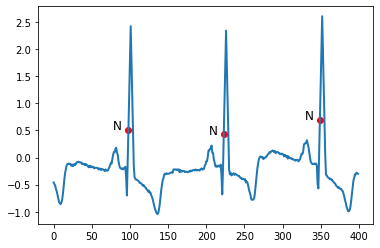

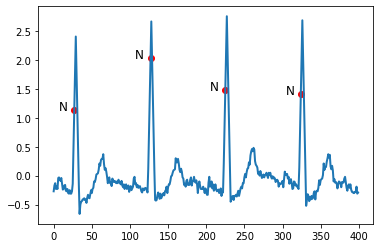

In [118]:
# plot first 5 signals 
for i in range(5):
    plot_signal(i,400)


In [151]:
# this function creates a patch for the defined signal & peak and save it in the "dataset_folder/Patches" folder 
# under the name of [SIGNAL_ID]_[peakID]_[LABEL].png
def create_patch(sigID,peakID):
    
    signal = ecg_signals[sigID]

    prev = rpeaks[sigID][peakID-1]
    peak = rpeaks[sigID][peakID]
    succ = rpeaks[sigID][peakID+1] 
    x = np.arange(int((peak+prev)/2),int((peak+succ)/2)) # lowest x is equal to the average between the peakID and the previous, dual for the highest x 
    y = signal[x,0]
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=2.0)
    
    plt.axis('off')         # axes are useless in input to the model 
    plt.savefig(dataset_folder+"//Patches//"+str(ids[sigID])+"_"+str(peakID)+"_"+labels[sigID][peakID]+".png",format="png",facecolor = "white",bbox_inches='tight',pad_inches = 0) # save the image 
   

    

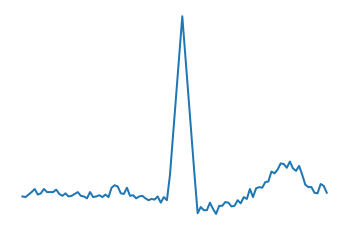

In [152]:
create_patch(4,7) # patch for the 4th signal, 7th peak (has to be cut properly)